### Get set up

In [2]:
# IMPORTS
import os
import pandas as pd
import numpy as np
from utils.load_utils import import_brava_data, get_exp_meta, normalise_shear, NumpyEncoder
from utils.data_utils import calculate_best_m_tau, calculate_lyapunov_exponents
import utils.plot_utils as plot
import matplotlib.pyplot as plt
from datetime import datetime
import json

# JUPYTER
# %matplotlib widget
%reload_ext autoreload
%autoreload 2

# FILENAMES
exp_code = "b1383"
run_code = "02"
working_dir = os.getcwd()
data_dir = working_dir + "/data"
results_dir = working_dir + "/results/" + run_code
if not "params" in globals():
    params={}
params.update({
    "working_dir": working_dir,
    "exp_code": exp_code,
    "run_code": run_code,
    "data_filename": data_dir + '/' + exp_code + '.txt',
    "data_picklename": data_dir + '/' + exp_code + '.pickle',
    "results_dir": results_dir
})
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Import data

Importing BRAVA data...
...reading data from file...
Resampling column: V-LVDT
Resampling column: H-LVDT
Resampling column: SHEAR STRESS
Resampling column: NORMAL STRESS
Resampling column: ON BOARD LVDT
Resampling column: V Load aux
Resampling column: Record
... data imported
      V-LVDT    H-LVDT  SHEAR STRESS  NORMAL STRESS  ON BOARD LVDT  \
0 -15.131615  5.226966      9.630810       7.497468    6249.136715   
1 -31.657716  6.178788      9.871680       7.497285    8772.464915   
2 -27.720415  5.952087      9.811924       7.497096    8172.364223   
3 -30.048910  6.086069      9.843103       7.497221    8527.502575   
4 -28.391140  5.990695      9.823957       7.497150    8275.512776   

   V Load aux         TIME        Record  NORMALISED SHEAR  
0    0.475953  1940.000000  2.810262e+06          0.654709  
1    0.493501  1940.050001  5.029166e+05          0.993747  
2    0.489146  1940.100001  1.052594e+06          0.909642  
3    0.491443  1940.150002  7.274995e+05          0.953531

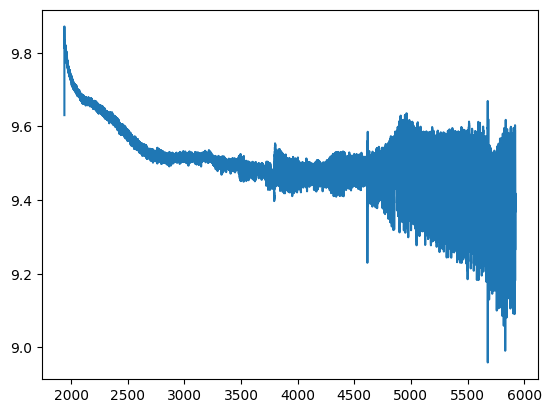

In [3]:
# IMPORT PARAMS
params.update({
    "exp_meta": get_exp_meta(params),
    "downsample_factor": 50
})

# IMPORT
data = import_brava_data(params)
print("... data imported")

# HAVE A LOOK
print(data.head())
plt.plot(data["TIME"], data["SHEAR STRESS"])

### Generate windows

In [5]:
win_length = 3000
win_offset = 1000
start_offset = 10
num_wins = (len(data) - win_length - start_offset) // win_offset
wins = np.empty((num_wins, 2), dtype=np.int_)
for i, _ in enumerate(wins):
    wins[i] = (i*win_offset + start_offset, i*win_offset + start_offset + win_length)

params.update({ "wins": wins, "save_wins": [4,8,20,40,65] })

### Runtime params

In [6]:

params.update({

    # CALCULATE BEST m, tau BY CAO (1997)
    "tau_to_try": np.array([5,10,15,20,25,30,35,40,45,50]),
    "m_to_try": np.arange(1,15,1),
    "E1_threshold": 0.9,
    "E2_threshold": 0.9,
    "eps_over_L0": 0.05,
    "n_neighbors": 20,

    # LYAPUNOV CALCULATIONS
    "LEs_sampling": ['rand',None]
})


# The loop

In [ ]:
FLAG_SAVE = True
params.update({ "run_start_time": datetime.now(), "current_loop": 0 })

results = []

for i, win in enumerate(params["wins"]):
    print("WINDOW ", (i+1), "/", len(params["wins"]))
    params.update({"current_loop": i})
    data_ = data[win[0]:win[1]].copy()
    data_ = normalise_shear(data_)

    m, tau = calculate_best_m_tau(data_, params, plot=(i in params["save_wins"]), save=FLAG_SAVE)
    print("Best m = ", m, ", tau=", tau)

    if ~np.isnan(m):
        LEs, KYD = calculate_lyapunov_exponents(data_, params, m, tau)
        print("Lyapunov Exponents:", LEs)
        print("Kaplan-Yorke dimension:", KYD)
    else:
        LEs = []
        KYD = np.nan

    results.append({ "t": data_.iloc[0].TIME, "m": m, "tau": tau, "LEs": LEs, "KYD": KYD })
    print("\n" + ("_"*20) + "\n")

results = pd.DataFrame(results)

plot.dimensionality_vs_time(data, results, params, save=FLAG_SAVE)
plot.tau_vs_time(data, results, params, save=FLAG_SAVE)

params.update({ "run_end_time": datetime.now() })

if FLAG_SAVE:
    results.to_csv(params["results_dir"] + "/results.csv")
    with open(params["results_dir"] + "/params.json", 'w') as f:
        f.write( json.dumps(params, cls=NumpyEncoder) )
    